> Tests for building preprocessing module.

---

# Setup

##### Set Root Dir as CWD

In [1]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


##### Imports

In [2]:
import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor

# Load

In [3]:
path = "data/yelp/reviews/"

In [4]:
%%time
# Load dev set (10% of total data) as train
train_all = pd.read_pickle(path + "train.xz")

CPU times: total: 28 s
Wall time: 28 s


In [5]:
%%time
# Load test set (10% of total data) as test
test_all = pd.read_pickle(path + "test.xz")

CPU times: total: 3.45 s
Wall time: 3.45 s


In [6]:
num_samples = (100, 100)

train = train_all.iloc[:num_samples[0]]
test = test_all.iloc[:num_samples[1]]

In [7]:
train

,text,stars
2903612,I like Wedding Belles for an odd reason. I set...,5
5050964,We had a great stay here. I felt like we got a...,5
1226557,"A unique place for sure, not your standard bre...",3
776083,This will be a short review on service and gri...,4
227582,Great barbershop. Super friendly staff. They a...,5
...,...,...
4191404,I smelled the cheap perfume from the moment I ...,2
2863388,I've eaten here once and been here for drinks ...,3
3951820,This place was horrible. It was very run down...,1
258,The food is average. Drink specials are great ...,3


##### Save Target

In [8]:
# Save reviews stars from 0-4
y_train = tf.convert_to_tensor(train["stars"].values - 1)
y_test = tf.convert_to_tensor(test["stars"].values - 1)

# Preprocess

In [9]:
train["text"].iloc[1]

"We had a great stay here. I felt like we got a lot of value for the price.  The room was very clean and the beds were comfy.  The complimentary breakfast was better than most.  Our boys love those waffle makers!  Every one was friendly and the atmosphere was a little historical but nicely updated.   Pull up to the back to check in.  Parking was $9/night and convenient.  We will definitely stay here again if the prices don't increase significantly when the Union Station Aquarium opens summer '19.  I highly recommend this place."

In [10]:
%%time
batch_size = 2000
n_processes = 4

maxlen = 200         # Number of words per review to consider
vocab_size = 30_000  # Size of vocabulary

prep = ReviewPreprocessor(vocab_size, maxlen, alpha_only=False, split_digits=True)

# Preprocess text
X_train_norm = prep.normalize(train["text"], batch_size, n_processes)
X_test_norm = prep.normalize(test["text"], batch_size, n_processes)

# Fit tokenizer
prep.fit_tokenizer(X_train_norm)

# Convert to tensor of padded sequences
X_train = prep.to_tensor(X_train_norm)
X_test = prep.to_tensor(X_test_norm)

CPU times: total: 1.09 s
Wall time: 20.3 s


In [11]:
%%time

prep2 = ReviewPreprocessor(vocab_size, maxlen, alpha_only=False, split_digits=True)

X_train2 = prep2.fit_transform(train["text"], batch_size, n_processes)
X_test2 = prep2.transform(test["text"], batch_size, n_processes)

CPU times: total: 1.03 s
Wall time: 20.3 s


In [22]:
tf.debugging.assert_equal(X_train, X_train2)

tf.debugging.assert_equal(X_test, X_test2)

In [25]:
pd.Series(X_train_norm).to_pickle("sandbox/test_prep.xz")

In [26]:
lol = pd.read_pickle("sandbox/test_prep.xz")
lol

0     [like, wedding, belles, odd, reason, ., set, a...
1     [great, stay, ., felt, like, got, lot, value, ...
2     [unique, place, sure, ,, standard, breakfast, ...
3     [short, review, service, grilled, oysters, ., ...
4     [great, barbershop, ., super, friendly, staff,...
                            ...                        
95    [smelled, cheap, perfume, moment, went, door, ...
96    [', ve, eaten, drinks, possibly, 3, e0, times,...
97    [place, horrible, ., run, shady, looking, clie...
98    [food, average, ., drink, specials, great, pla...
99    [eating, fried, seafood, sorts, po, boys, nola...
Length: 100, dtype: object

##### I/O test

In [20]:
prep.save_as_pickle("sandbox/test.pickle")

In [21]:
load_prep = ReviewPreprocessor.load_from_pickle("sandbox/test.pickle")

In [18]:
prep.split_digits

True

In [19]:
load_prep.split_digits

True

##### View Before and After Preprocessing

In [26]:
print_idx = 0
print(test["text"].iloc[print_idx])
print("\n - - - - \n")
print(X_test_norm[print_idx], len(X_test_norm[print_idx]))
print("\n - - - - \n")
print(X_test[print_idx])

I have never been more frightened in my life.  I screamed, fell on the floor, and ran for my life.  I was literally covered in sweat and needed my inhaler multiple times.  The campus is huge and VIP is definitely the move.  Pennhurst is an amazing campus with lots of history and the actors are fully committed to making the experience hair raising.  I would suggest this place to anyone looking for a frighting experience.

 - - - - 

['frightened', 'life', '.', 'screamed', ',', 'fell', 'floor', ',', 'ran', 'life', '.', 'literally', 'covered', 'sweat', 'needed', 'inhaler', 'multiple', 'times', '.', 'campus', 'huge', 'vip', 'definitely', '.', 'pennhurst', 'amazing', 'campus', 'lots', 'history', 'actors', 'fully', 'committed', 'making', 'experience', 'hair', 'raising', '.', 'suggest', 'place', 'looking', 'frighting', 'experience', '.'] 43

 - - - - 

tf.Tensor(
[ 133    1    2  802    2  133    1 1752  348  987   63    1  311   28
    1  147  706  583  286   57  399    1  957   13  103   57

# Model

* Reference https://keras.io/examples/nlp/text_classification_with_transformer/

##### Embedding Layer Definition

In [125]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, name=None):
        super(TokenAndPositionEmbedding, self).__init__(name=name)
        
        # Token embedding
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        
        # Position embedding
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)

        x = self.token_emb(x)
        return x + positions

##### Model Definition

In [126]:
class SentimentClassifier(tf.keras.Model):
    def __init__(self, maxlen, vocab_size, embed_dim, num_heads, ff_dims,
                 reg=1e-3, dropout=0.3):
        super().__init__()
        
        # Token embedding
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,
                                          mask_zero=True, name="t_emb")
        
        # Position embedding
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim,
                                        name="p_emb")
        
        # Attention based on token and positional info
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,
                                             name="attention")
        
        # Feed-forward network with a layer for each number of neurons in ff_dims
        ffn_layers = []
        for dim in ff_dims:
            layer = layers.Dense(dim, activation="relu", 
                                 kernel_regularizer=keras.regularizers.l2(reg))
            ffn_layers.append(layer)
        self.ffn = keras.Sequential(ffn_layers)
        
        # Speed and regularization
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)
        
        # Average 
        self.pool = layers.GlobalAveragePooling1D()
        self.dropout3 = layers.Dropout(dropout)
        self.dense = layers.Dense(20, activation="relu", 
                                  kernel_regularizer=keras.regularizers.l2(reg))
        self.dropout4 = layers.Dropout(dropout)
        
        # 5-star review probability output
        self.stars = layers.Dense(5, activation="softmax")
        
    def call(self, x, training=False, return_att=False):
        mask = self.token_emb.compute_mask(x)
        mask = mask[:, tf.newaxis, tf.newaxis, :]
        
        # Embed tokens and positional encodings
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        x = x + positions
        
        # Self attention (query = key) -> feed-forward network (w/ add & norm)
        attn_output, attn_scores = self.att(x, x, attention_mask=mask, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        x = self.layernorm2(out1 + ffn_output)
        
        # Average pooling (along each time step), dropout, one more dense layer
        x = self.pool(x)
        x = self.dropout3(x)
        x = self.dense(x)
        x = self.dropout4(x)
        
        # Softmax for 5-star rating probabilities
        rating_probs = self.stars(x)
        
        if return_att:
            return rating_probs, attn_scores

        return rating_probs

##### Create Model

In [127]:
# Hyperparameters
embed_dim = 32  # Embedding size for each token
num_heads = 1   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer
reg = 5.0e-2
dropout = 0.5

# Model
model = SentimentClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)

In [128]:
model.predict(X_train[:5])

1/1 [==============================] - 0s 198ms/step


array([[0.17296666, 0.21564558, 0.22278912, 0.2776162 , 0.11098247],
       [0.16306902, 0.22724825, 0.22297053, 0.2785107 , 0.10820156],
       [0.15289932, 0.24095337, 0.23662631, 0.2787078 , 0.09081316],
       [0.16964918, 0.22512959, 0.20787346, 0.2813835 , 0.11596423],
       [0.1536684 , 0.23075542, 0.23427399, 0.287606  , 0.09369616]],
      dtype=float32)

##### Compile and Run

In [129]:
learning_rate = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate), 
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.build(X_train.shape)

In [130]:
model.summary()

Model: "sentiment_classifier_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 t_emb (Embedding)           multiple                  960000    
                                                                 
 p_emb (Embedding)           multiple                  6400      
                                                                 
 attention (MultiHeadAttenti  multiple                 4224      
 on)                                                             
                                                                 
 sequential_4 (Sequential)   (None, 200, 32)           1056      
                                                                 
 layer_normalization_8 (Laye  multiple                 64        
 rNormalization)                                                 
                                                                 
 layer_normalization_9 (Laye  multiple      

In [131]:
%%time
# Train model
epochs = 5

# Early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

# Checkpoint
checkpoint_path = "model_checkpoints/proto.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
create_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1)

history = model.fit(
    X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test),
    callbacks=[early_stopping], verbose=1,
)

Epoch 1/5
62500/62500 [==============================] - 208s 3ms/step - loss: 0.8820 - accuracy: 0.6452 - val_loss: 0.8477 - val_accuracy: 0.6350
Epoch 2/5
62500/62500 [==============================] - 219s 4ms/step - loss: 0.8451 - accuracy: 0.6555 - val_loss: 0.8401 - val_accuracy: 0.6254
Epoch 3/5
62500/62500 [==============================] - 208s 3ms/step - loss: 0.8354 - accuracy: 0.6591 - val_loss: 0.8231 - val_accuracy: 0.6574
Epoch 4/5
62500/62500 [==============================] - 214s 3ms/step - loss: 0.8297 - accuracy: 0.6611 - val_loss: 0.8280 - val_accuracy: 0.6502
Epoch 5/5
62500/62500 [==============================] - 210s 3ms/step - loss: 0.8254 - accuracy: 0.6626 - val_loss: 0.8043 - val_accuracy: 0.6626
CPU times: total: 23min 12s
Wall time: 17min 39s


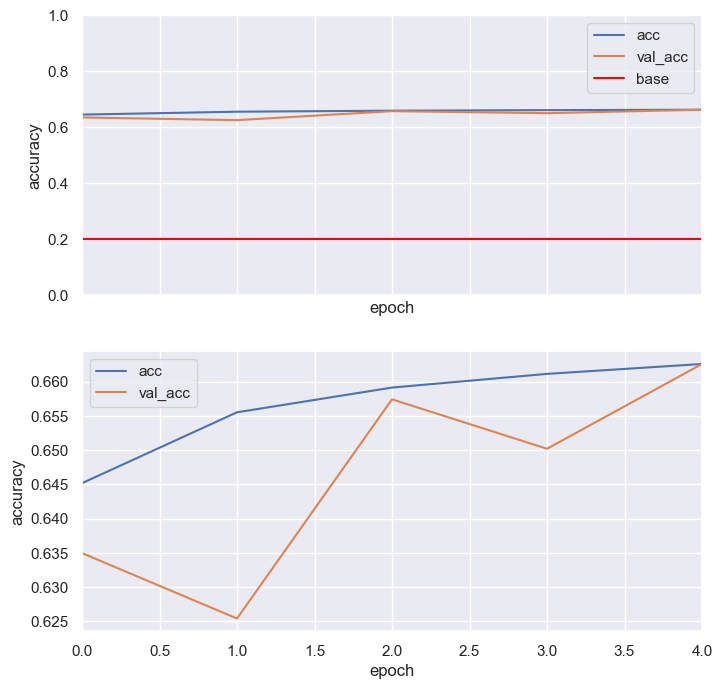

In [142]:
hist = history.history
acc, val_acc = hist["accuracy"], hist["val_accuracy"]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8), dpi=100)

for i, ax in enumerate(axes):
    ax.plot(acc, label="acc")
    ax.plot(val_acc, label="val_acc")
    
    ax.set_xlim(0, epochs - 1)
    if i == 0:
        ax.set_ylim(0.0, 1.0)
        ax.axhline(0.2, color="red", label="base")
        
    ax.grid(visible=True, axis="both")
    ax.legend()
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")

plt.show()

##### Test

In [143]:
# Get probabilities per class
y_pred = model.predict(X_test)

3125/3125 [==============================] - 3s 1ms/step


In [144]:
# Get star predictions and negative/positive predictions
y_pred_multi = tf.argmax(y_pred, axis=1)
y_pred_binary = y_pred_multi >= 3

In [145]:
print("multi-class accuracy: " + str((y_pred_multi == y_test).numpy().sum() / len(y_test)))
print("(compare to ~0.2)")

multi-class accuracy: 0.66258
(compare to ~0.2)


In [146]:
print("binary accuracy: " + str((y_pred_binary == (y_test >= 3)).numpy().sum() / len(y_test)))
print("(compare to ~0.5)")

binary accuracy: 0.90989
(compare to ~0.5)


##### Visualize Attention

In [156]:
# Get attention scores
_, attns = model(X_test[:100], return_att=True)

# Get attention for each sample
attns = tf.reduce_mean(attns, axis=2)[:, 0, :]
attns

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[0.07764458, 0.05308972, 0.0349667 , ..., 0.        , 0.        ,
        0.        ],
       [0.1300747 , 0.08431643, 0.04220372, ..., 0.        , 0.        ,
        0.        ],
       [0.10003831, 0.09676443, 0.00456091, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06990457, 0.11007544, 0.02202518, ..., 0.        , 0.        ,
        0.        ],
       [0.14435484, 0.02092621, 0.0733385 , ..., 0.        , 0.        ,
        0.        ],
       [0.07704394, 0.03665083, 0.02144636, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [157]:
attns[0][:34]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([0.07764458, 0.05308972, 0.0349667 , 0.03753987, 0.0230421 ,
       0.01863576, 0.03119095, 0.02512748, 0.01513603, 0.01720031,
       0.02892672, 0.02990903, 0.0151534 , 0.0182085 , 0.02541119,
       0.02710303, 0.01407397, 0.06770805, 0.02609011, 0.05646799,
       0.02792396, 0.02753072, 0.02816499, 0.0256967 , 0.01896237,
       0.01507911, 0.02147102, 0.01475192, 0.01935074, 0.04306125,
       0.02045472, 0.02617007, 0.02377341, 0.02942504], dtype=float32)>

In [158]:
seq_len

26

In [159]:
tokenizer

<Original Text>
Overall very disappointing experience with Audi Kirkwood.  Bought a 2014 Audi from this dealership.  Immediately after sale experienced change in responsiveness from representatives.  Emails went weeks without answers that were before answered within 1 day.  Recently brought vehicle back for recall (side curtain airbag issue requiring inspection and fix).  When I bought the car the sales staff had 'lost' the card that allows them to fill the car with gas, so told me to ask for a tank next time I was in.  I did so.  The tank was not refilled.  I also mentioned a high-pitched whine it was making and was told they would look into it. When I picked up the car I was told they didn't look at that, without further explanation.  Lastly, my side airbag covers are now themselves covered in greasy handprints.  Not what one expects from a luxury car dealership.  I recommend steering clear of Audi Kirkwood.  My last car purchase was a VW within the Bommarito family, and I had only g

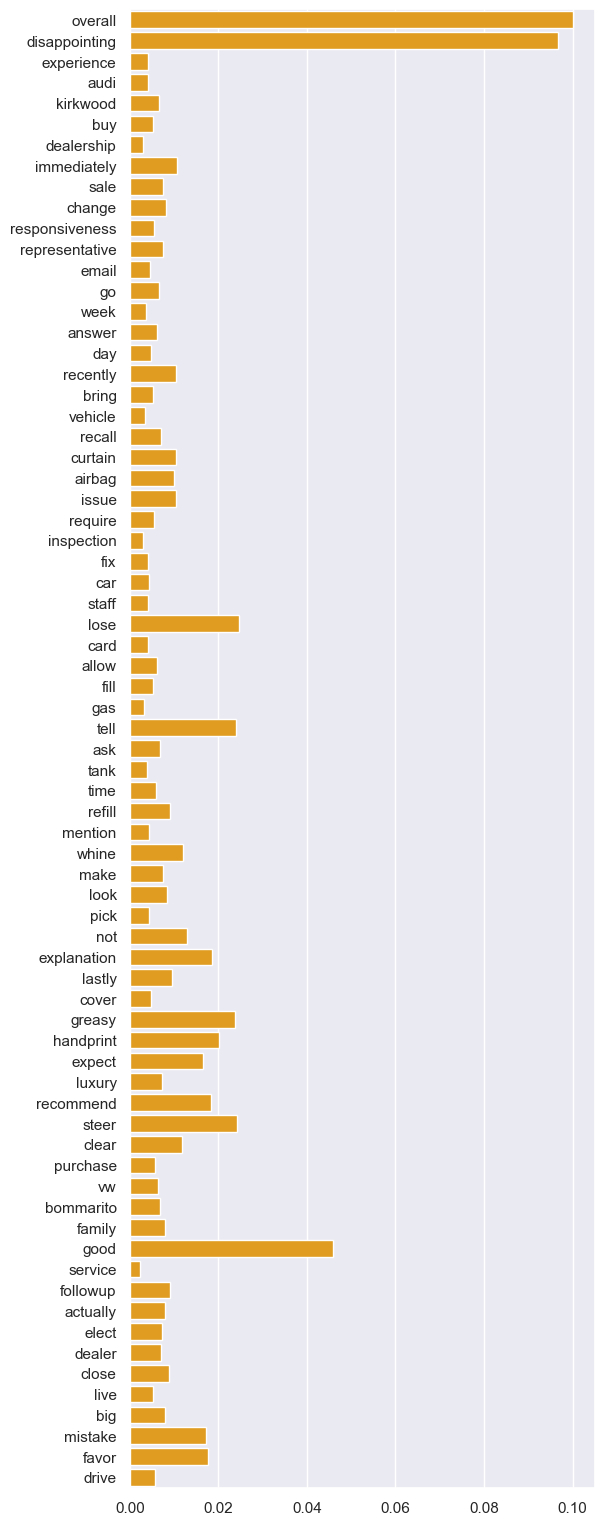

In [161]:
sample_idx = 2

# Get word sequences without oov words
in_seq = X_test_norm[sample_idx]
in_seq = [tok for tok in tokenizer.sequences_to_texts(tokenizer.texts_to_sequences(in_seq)) if tok]
seq_len = len(in_seq)

# Get attention values
attn_vals = attns[sample_idx][:seq_len].numpy()

print("<Original Text>")
print(test["text"].iloc[sample_idx])

print("\n<Preprocessed>")
print(in_seq)

plt.figure(figsize=(6, 0.2 * seq_len), dpi=100)
sns.barplot(y=in_seq, x=attn_vals, ci=None, color="orange")

plt.show()